# Thompson Sampling and the Bernoulli Bandit

Let's explore Thompson sampling as a simple strategy for balancing exploration and exploitation in a (sort of) real-world setting. We'll do this in the simple situation of the two-armed Bernoulli bandit.

### Optimizing Click-Through Rates

Imagine we are trying to compare some proposed process with our current status quo. For example, maybe we're trying to determine if a new e-mail newsletter layout drives click-throughs to our website more often than the layout we're currently using. This problem is an example of a two-armed bandit - we have a choice between two "arms" and we want to discover and select the arm that has the maximum reward. More to the point, we want to balance exploration (determining which arm is the best) and exploitation (pulling the arm that we believe is best) to maximize cumulative payoff. 

After taking each action, we receive a binary reward with the form $\textrm{Reward}_k \sim \textrm{Bernoulli}(\theta _k)$. This is a simple situation to simulate and does reasonably well approximating many real-world bandit problems, where the only two measurable outcomes are success or failure. 

### Simulating the Problem

In order to somewhat approximate reality, let's create a blackbox `EmailOracle` class that represents the information we get about each email view after we send it. Practically speaking, this may be information that lives in analytics database that we need to query, but in this case we'll have it print either `C` (conversion) or `N` (*No* conversion) to console, where `C` represents an email view that converted to a click-through. 

We'll intentionally set it up such that the new action has a small but real lift over the status quo (8% vs 5%), so ideally our online learning algorithm can identify it as the better option.

In [1]:
import numpy as np
from numpy.typing import NDArray

TRUE_PROB_OF_CONVERSION_FOR_STATUS_QUO = 0.05
TRUE_PROB_OF_CONVERSION_FOR_PROPOSED_ACTION = 0.08

class EmailOracle:
    def __init__(self, a: float, b: float):
        self.a = a
        self.b = b
        self.rewards_history = []

    def status_quo_action(self):
        """
        Gives the (probabilistic) result when the status quo action is taken
        """
        reward = ["N", "C"][np.random.binomial(1, self.a)]
        self.rewards_history.append(reward)

    def new_proposed_action(self):
        """
        Gives the (probabilistic) result when the new proposed action is taken
        """
        reward = ["N", "C"][np.random.binomial(1, self.b)]
        self.rewards_history.append(reward)

two_armed_bandit = EmailOracle(TRUE_PROB_OF_CONVERSION_FOR_STATUS_QUO, TRUE_PROB_OF_CONVERSION_FOR_PROPOSED_ACTION)


### Setting up the learning agent

Next, we can use the `bayesianbandits` library to set up a learning agent. First, let's define a learner that will accumulate our best knowledge regarding each arm. Because this is a Bernoulli bandit, we'll use a Dirichlet (multivariate beta) classifier. Because the Dirichlet distribution is the conjugate prior to the Binomial and Multinomial distributions, it will be simple to compute an analytical Bayesian update after each arm pull.

In regards to priors, we'll choose an uninformative $\textrm{Dirichlet}(0.5, 0.5)$ prior, which essentially encodes that we believe either email may be better, but we have no idea how good either will be. [See the wikipedia page of the Dirichlet distribution for more details](https://en.wikipedia.org/wiki/Dirichlet_distribution). The `alphas` are the parameters of the `Dirichlet` distribution, just like $\mu, \sigma$
 are the parameters of a normal distribution.


In [2]:
from bayesianbandits import DirichletClassifier

# We won't be using this particular instantiation, this is just an example of how it can be defined with the (0.5, 0.5) prior
clf = DirichletClassifier(alphas={"C": 0.5, "N": 0.5})
clf.alphas.keys()

dict_keys(['C', 'N'])


Additionally, we need to define functions that represent the action space and function(s) to compute the reward. Because we consider an output of `C` a success and an output of `N` a failure, we'll have our reward function return the value of the `C` column of our `clf.classes_` array. The `.classes_` won't be initialized until the learner learns from the data at least once, but you can see the order of the classes in `clf.alphas.keys()`

*Aside: [as defined in _arm.py](https://github.com/bayesianbandits/bayesianbandits/blob/8378f2566153285a224f42ca9667e2d22f9f472b/bayesianbandits/_arm.py#L15), a reward function takes samples from the posterior as input and returns either a float or an array of floats. The sampling itself is handled through the `learner`*



In [3]:
from enum import Enum

conversion_column_index = list(clf.alphas.keys()).index('C') # This will be the 0 index

class EmailActions(Enum):
    STATUS_QUO = 0
    NEW_PROPOSAL = 1

    def take_action(self, email: EmailOracle):
        if self == EmailActions.STATUS_QUO:
            email.status_quo_action()
        elif self == EmailActions.NEW_PROPOSAL:
            email.new_proposed_action()

def reward_func(samples: NDArray[np.float64]) -> NDArray[np.float64]:
    return samples[..., conversion_column_index]


Now we can define our learning agent. We first define the arms. Each arm requires an `action_token` (the token that is returned when that particular arm is pulled), a reward function and a learner. This `learner` defines how each arm will learn how rewarding its action is, 

With those arms, we can then define an `Agent`. An `Agent` is defined by a list of arms and a policy, which determines how the agent chooses which arm to pull. In this case, we'll use `ThompsonSampling`, which takes no parameters.

In [4]:
from bayesianbandits import DirichletClassifier, Arm, Agent, ThompsonSampling

arms = [
    Arm(
        EmailActions(0),
        reward_func,
        learner=DirichletClassifier(alphas={"C": 0.5, "N": 0.5}),
    ),
    Arm(
        EmailActions(1),
        reward_func,
        learner=DirichletClassifier(alphas={"C": 0.5, "N": 0.5}),
    ),
]


agent = Agent(arms, ThompsonSampling())

Now, let's simulate some online learning. To somewhat approximate the process of capturing data and feeding it to the agent, we'll use the `.rewards_history` from the oralce and then update the agent with the last observed reward. Let's simulate 5000 observations.

In [5]:
for _ in range(5000):
    action, = agent.pull()
    action.take_action(two_armed_bandit)
    agent.update(np.atleast_1d(two_armed_bandit.rewards_history[-1]))


Let's see how our agent did. First, we can sample from the posterior distributions of each arm to determine the agent's belief about how rewarding each arm is.

We can see that the new proposal arm has been correctly been identified as the better arm, and the posterior distribution is narrower, suggesting that the agent spent more time pulling that arm.

*An optional aside on the `agent.arms[0].sample(np.array([[1]]))` syntax: this expression is sampling the reward function based on the posterior distribution. What is this `np.array([[1]])`doing? This is actually the context of the agent. Each context gets a different set of `alphas`, so the learner has a dictionary to keep track of the sets of `alphas` (the keys are the context, the values are the alphas). Since we are using a non contextual bandit here, we have just one set of alphas and that's the one we are extracting with this `[1]` key. Think of this `[1]` as a global intercept that identifies the single context we are considering*


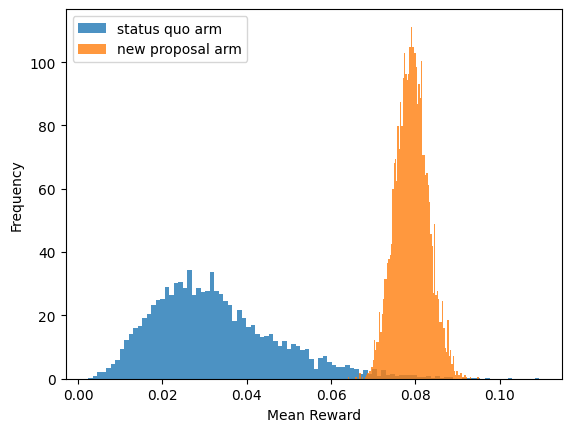

In [6]:
import matplotlib.pyplot as plt

arm_1_data = agent.arms[0].sample(np.array([[1]]), size=5000).flatten()
arm_2_data = agent.arms[1].sample(np.array([[1]]), size=5000).flatten()

plt.hist(
    arm_1_data,
    alpha=0.8,
    label="status quo arm",
    density=True,
    stacked=True,
    bins=100
)
plt.hist(
    arm_2_data,
    alpha=0.8,
    label="new proposal arm",
    density=True,
    stacked=True,
    bins=100
)

plt.xlabel("Mean Reward")
plt.ylabel("Frequency")

plt.legend()

plt.show()


This is a sort of contrived situation - in the experiment described above, we wouldn't actually know the reward of each action immediately - in reality, our agent would have to pull several arms, and then at some later point it would need to be updated. To facilitate this, `bayesianbandits` allows pulling in batches, and then updating the agent with the results of the batch. 

Let's simulate what that might look like. Our online learning experiment now consists of two steps:

1. Be presented with n choices to make
2. Update the learner with the results of those n choices
3. Repeat some number of times

Let's say that we're going to send out 100 emails a week, and we'll assume, for the sake of this simulation, that we gather data about each of those 100 emails by the end of the week. We'll repeat this process over 10 weeks.

In [7]:
for week in range(10):

    feedback: list[str] = []

    # make 100 pulls per week
    actions: list[EmailActions] = []
    for email_idx in range(100):
        actions.extend(agent.pull())
        actions[-1].take_action(two_armed_bandit)
        feedback.append(two_armed_bandit.rewards_history[-1])
        
    # update the agent with the feedback at the end of the week.
    # this can be done in batches, but for simplicity we do it
    # one at a time.

    for a_, f_ in zip(actions, feedback):
        agent.select_for_update(a_).update(np.atleast_1d(f_))


We can see from the posterior distribution of each arm that the agent essentially learned the same information it learned above. 

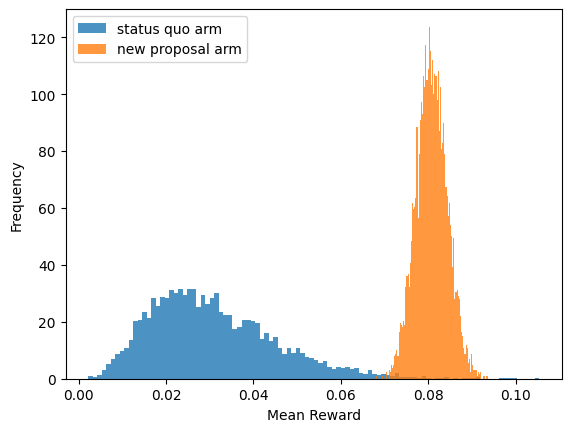

In [8]:
plt.hist(
    agent.arms[0].sample(np.array([[1]]), size=5000).flatten(),
    alpha=0.8,
    label="status quo arm",
    density=True,
    stacked=True,
    bins=100
)
plt.hist(
    agent.arms[1].sample(np.array([[1]]), size=5000).flatten(),
    alpha=0.8,
    label="new proposal arm",
    density=True,
    stacked=True,
    bins=100
)

plt.xlabel("Mean Reward")
plt.ylabel("Frequency")

plt.legend()

plt.show()


Let's add another touch of realism to our above example. We're not actually going to leave our code running all week - we want to run a job on Monday to send all of the emails, and then run a separate job on Sunday to update the agent. There are innumerable ways to do this, but the simplest is to use the `joblib` package, which is utilized by `scikit-learn` to simplify model persistence. Agents created by `bayesianbandits` are also fully-compatible with `joblib`, and can be persisted and reloaded with the `dump` and `load` methods.

We can ensure downstream type-safety by annotating the loaded agent with the underlying learner type and the action token type.

In [9]:
import joblib

joblib.dump(agent, "agent.pkl")

agent: Agent[DirichletClassifier, EmailActions, ThompsonSampling] = joblib.load("agent.pkl")